In [18]:
from langchain_groq import ChatGroq
from langchain.agents import tool, create_react_agent
import datetime
from langchain_community.tools import TavilySearchResults
from langchain import hub
import operator
from typing import Annotated, TypedDict, Union
from typing import List
from langchain_core.prompts import PromptTemplate
from langchain_core.agents import AgentAction, AgentFinish
from langgraph.graph import END, StateGraph
from langchain_core.agents import AgentAction, AgentFinish

from dotenv import load_dotenv
import os

In [19]:
load_dotenv()
os.environ["GROQ_API_KEY"] = os.getenv('Groq') # type: ignore
os.environ["TAVILY_API_KEY"] = os.getenv('Tavily') # type: ignore

llm = ChatGroq(model="llama3-8b-8192",temperature=0.5,)

In [20]:
class AgentState(TypedDict):
    input: str
    agent_outcome: Union[AgentAction, AgentFinish, None]
    intermediate_steps: Annotated[list[tuple[AgentAction, str]], operator.add]
    loop_counter:int


In [21]:

@tool
def web_search(query: str)->str:
    """Search the web for current information and news."""
    tavily = TavilySearchResults()
    result = tavily.invoke(query)
    formatted_results = []
    if isinstance(result, list): 
        for item in result:
            if isinstance(item, dict): 
                title = item.get('title', 'No Title')
                url = item.get('url', 'No URL')
                content = item.get('content', 'No Content')
                truncated_content = (content[:200] + '...') if len(content) > 200 else content
                formatted_results.append(f"Title: {title}\nURL: {url}\nContent: {truncated_content}\n---")
            else:
                formatted_results.append(f"Unexpected item type: {item}")
        formatted_output = "\n".join(formatted_results)
    else:
        formatted_output = str(result) 

    return formatted_output



In [22]:
@tool
def get_system_time(format: str = "%Y-%m-%d %H:%M:%S"):
    """ Returns the current date and time in the specified format """

    current_time = datetime.datetime.now()
    formatted_time = current_time.strftime(format)
    return formatted_time

In [23]:


# Fixed custom prompt
REACT_PROMPT_TEMPLATE = """Answer the following questions as best you can. You have access to the following tools:

{tools}

Use the following format:

Question: the input question you must answer
Thought: you should always think about what to do
Action: the action to take, should be one of [{tool_names}]
Action Input: the input to the action
Observation: the result of the action
... (this Thought/Action/Action Input/Observation can repeat N times)
Thought: I now know the final answer
Final Answer: the final answer to the original input question

Begin!

Question: {input}
Thought:{agent_scratchpad}"""

tools = [get_system_time, web_search]

# Create the prompt template
react_prompt = PromptTemplate(
    template=REACT_PROMPT_TEMPLATE,
    input_variables=['input', 'agent_scratchpad'],
    partial_variables={
        'tools': '\n'.join([f"{tool.name}: {tool.description}" for tool in tools]),
        'tool_names': ', '.join([tool.name for tool in tools])
    }
)

In [24]:
REACT_PROMPT = """
Answer the following questions as best you can using the tools available.

You have access to the following tools:
{tool_names}

In every step, follow this strict format:

Question: the question you are answering
Thought: think about what to do first, do not jump to tools without reasoning.
Action: the action to take, must be one of [{tool_names}]
Action Input: the input to the action

When you get the final answer, respond with:

Final Answer: the final answer to the original question.

Additional guidelines:
- If the question involves "how many days ago", "how many days after", or "X days between two events", you may need to use the system time.
- But DO NOT call get_system_time unless you already have another known date (like from web_search).
- If the date of an event is available on the web, retrieve it first, then compute time difference ONLY IF the question demands it.
- Avoid calling get_system_time repeatedly. Use it only once and only when absolutely required.
- If the user's question does not involve dates or durations, you must not use get_system_time.
- Always use the minimum number of steps to answer the question accurately.

Begin!

Question: {input}
Thought:
"""


In [25]:

tools = [get_system_time,web_search]

react_prompt = hub.pull("hwchase17/react")

react_agent_runnable = create_react_agent(
    llm=llm,
    tools=tools,
    prompt=react_prompt,
)




e:\Python_PIP\RAG\virtualenv\Lib\site-packages\langsmith\client.py:272: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


In [26]:
print(react_prompt)
print("---------")
print(react_agent_runnable.__dict__)

input_variables=['agent_scratchpad', 'input', 'tool_names', 'tools'] input_types={} partial_variables={} metadata={'lc_hub_owner': 'hwchase17', 'lc_hub_repo': 'react', 'lc_hub_commit_hash': 'd15fe3c426f1c4b3f37c9198853e4a86e20c425ca7f4752ec0c9b0e97ca7ea4d'} template='Answer the following questions as best you can. You have access to the following tools:\n\n{tools}\n\nUse the following format:\n\nQuestion: the input question you must answer\nThought: you should always think about what to do\nAction: the action to take, should be one of [{tool_names}]\nAction Input: the input to the action\nObservation: the result of the action\n... (this Thought/Action/Action Input/Observation can repeat N times)\nThought: I now know the final answer\nFinal Answer: the final answer to the original input question\n\nBegin!\n\nQuestion: {input}\nThought:{agent_scratchpad}'
---------
{'name': None, 'first': RunnableAssign(mapper={
  agent_scratchpad: RunnableLambda(lambda x: format_log_to_str(x['intermedia

In [27]:
def reason_node(state: AgentState):
    agent_outcome = react_agent_runnable.invoke(state)
    print("__reason_node__.state",state)
    print("---------")
    print("__reason_node__.agent_outcome",agent_outcome)
    print("---------")
    return {"agent_outcome": agent_outcome,
            "loop_counter": state["loop_counter"] + 1
            }


In [28]:
def act_node(state: AgentState):
    agent_action = state["agent_outcome"]
    print("__act_node__.state", state)
    
    # Extract tool name and input from AgentAction
    tool_name = agent_action.tool
    tool_input = agent_action.tool_input
    
    # Find the matching tool function
    tool_function = None
    for tool in tools:
        if tool.name == tool_name:
            tool_function = tool
            break
    
    # Execute the tool with the input - FIXED LOGIC
    if tool_function:
        try:
            # Handle different input types properly
            if tool_input is None or tool_input == 'None' or tool_input == '':
                # Call with no arguments (use defaults)
                output = tool_function.invoke({})
            elif isinstance(tool_input, dict):
                # Call with dictionary unpacking
                output = tool_function.invoke(**tool_input)
            elif isinstance(tool_input, str):
                # For string inputs, determine the parameter name
                if tool_name == 'web_search':
                    output = tool_function.invoke({"query": tool_input})
                elif tool_name == 'get_system_time':
                    output = tool_function.invoke({"format": tool_input})
                else:
                    output = tool_function.invoke(tool_input)
            else:
                # Direct invocation for other types
                output = tool_function.invoke(tool_input)
        except Exception as e:
            output = f"Error executing tool '{tool_name}': {str(e)}"
    else:
        output = f"Tool '{tool_name}' not found"
    
    return {"intermediate_steps": [(agent_action, str(output))]}

In [29]:
def should_continue(state: AgentState) -> str:
    state["loop_counter"] += 1
    if state["loop_counter"] > 5:
        return "end"
    if isinstance(state["agent_outcome"], AgentFinish):
        return "end"
    else:
        return "act_node"

In [30]:
graph = StateGraph(AgentState)

graph.add_node("reason_node", reason_node)
graph.set_entry_point("reason_node")
graph.add_node("act_node", act_node)


graph.add_conditional_edges(
    "reason_node",
    should_continue,
    {"end":END,"act_node":"act_node"}
)

graph.add_edge("act_node", "reason_node")

app = graph.compile()



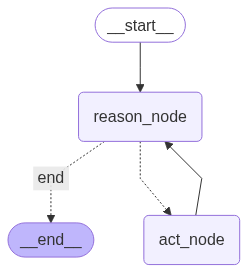

In [31]:
from IPython.display import Image, display

try:
    display(Image(app.get_graph().draw_mermaid_png()))
except Exception:
    pass

In [32]:
result = app.invoke(
    {
        "input": "How many days ago DRDO tested latest Pralay missile according to news from public domain?", 
        "agent_outcome": None, 
        "intermediate_steps": [],
        "loop_counter":0
    }
)


__reason_node__.state {'input': 'How many days ago DRDO tested latest Pralay missile according to news from public domain?', 'agent_outcome': None, 'intermediate_steps': [], 'loop_counter': 0}
---------
__reason_node__.agent_outcome tool='web_search' tool_input='DRDO Pralay missile test' log='Thought: I need to find out when the DRDO tested the latest Pralay missile. I can use the web search tool to get the latest information.\n\nAction: web_search\nAction Input: "DRDO Pralay missile test"'
---------
__act_node__.state {'input': 'How many days ago DRDO tested latest Pralay missile according to news from public domain?', 'agent_outcome': AgentAction(tool='web_search', tool_input='DRDO Pralay missile test', log='Thought: I need to find out when the DRDO tested the latest Pralay missile. I can use the web search tool to get the latest information.\n\nAction: web_search\nAction Input: "DRDO Pralay missile test"'), 'intermediate_steps': [], 'loop_counter': 1}
__reason_node__.state {'input':

In [33]:
print(result)

{'input': 'How many days ago DRDO tested latest Pralay missile according to news from public domain?', 'agent_outcome': AgentFinish(return_values={'output': 'The DRDO tested the latest Pralay missile on July 29, 2025, which is 2 days ago as of the current system time (2025-07-31 13:20:19).'}, log='Here is the continuation of the answer:\n\nThought: I now know the final answer.\n\nFinal Answer: The DRDO tested the latest Pralay missile on July 29, 2025, which is 2 days ago as of the current system time (2025-07-31 13:20:19).'), 'intermediate_steps': [(AgentAction(tool='web_search', tool_input='DRDO Pralay missile test', log='Thought: I need to find out when the DRDO tested the latest Pralay missile. I can use the web search tool to get the latest information.\n\nAction: web_search\nAction Input: "DRDO Pralay missile test"'), 'Title: India completes tests of Pralay ballistic missiles clearing final step ...\nURL: https://armyrecognition.com/news/army-news/2025/india-completes-tests-of-pr

In [35]:
print(result["input"])
print("------")
print(result["intermediate_steps"][0][0])
print("------")
print(result["agent_outcome"].return_values["output"])# 

How many days ago DRDO tested latest Pralay missile according to news from public domain?
------
tool='web_search' tool_input='DRDO Pralay missile test' log='Thought: I need to find out when the DRDO tested the latest Pralay missile. I can use the web search tool to get the latest information.\n\nAction: web_search\nAction Input: "DRDO Pralay missile test"'
------
The DRDO tested the latest Pralay missile on July 29, 2025, which is 2 days ago as of the current system time (2025-07-31 13:20:19).


In [ ]:
#